# Meteorology Data Extraction

In this notebook, we will:
1. Run code to associate sample plots (fields) with their nearest GridMET cell.
2. Extract GridMET bias-correction information from DRI's rasters.
3. Use a simple Python API that downloads GridMET data from the THREDDS server.



In [1]:
import os
import sys
# Import the necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt

# Set matplotlib to display inline
%matplotlib inline

Let's load the shapefile again.

78 fields


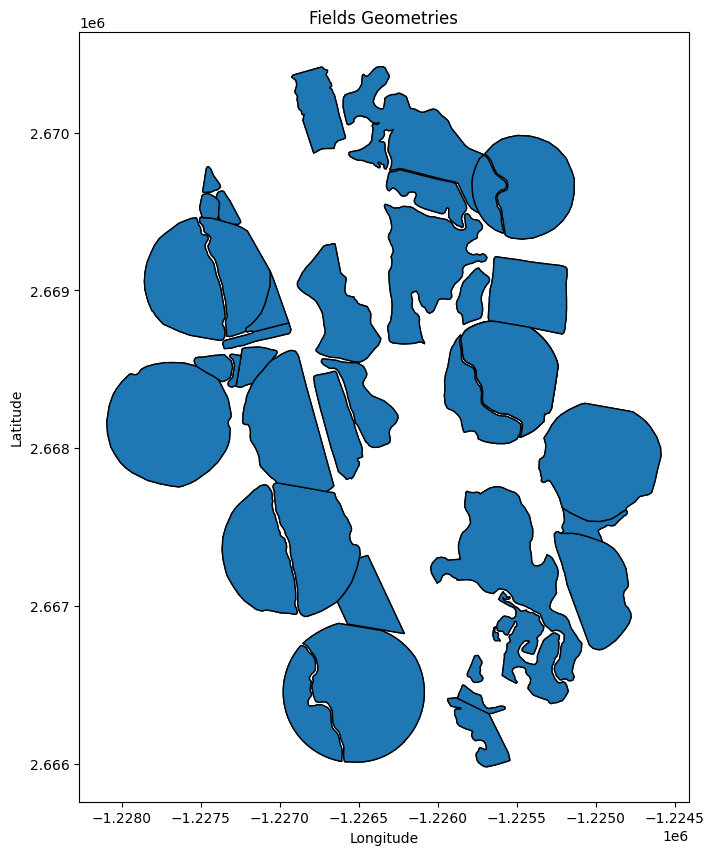

In [2]:
# Load the shapefile
cwd = os.getcwd()

shapefile_dir = os.path.join(os.path.dirname(cwd), 'step_1_domain')
shapefile_path = os.path.join(shapefile_dir, 'mt_sid_boulder.shp')
gdf = gpd.read_file(shapefile_path)

# Display the first few rows of the GeoDataFrame to examine structure and attributes
gdf.head()
print(gdf.shape[0], 'fields')

# Plot the shapefile geometries
gdf.plot(figsize=(10, 10), edgecolor='black')
plt.title('Fields Geometries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Our fields are in a pretty tight cluster. We're preparing to download meteorology from a 4-km resolution dataset (GridMET), so it's unnecessary to download a new meteorology time series for each field. Rather, we'll identify the Gridmet 'cells' with a shapefile, and find the closest cell to each field.

In addition to the raw meteorology data, we will also be accessing rasters that show the observed bias between Agrimet and Agrimet-like weather stations. These biases are often due to the impacts of irrigated agriculture on the near-surface atmosphere, which often tend to increase humidity and lower temperature compared to arid and semi-arid surroundings. This bias is well-documented in Blankeneau (2019; https://doi.org/10.1016/j.agwat.2020.106376). The bias correction surfaces were developed by Desert Research Institute and are documented in Melton et al., 2021 (https://doi.org/10.1111/1752-1688.12956). They are rasters in GridMET's native format.

Looking at the Gridmet grid, we see we will only need a few cell's data.

In [3]:
# load the centroids
cetnroids_path = 'gridmet_centroids.shp'
cdf = gpd.read_file(cetnroids_path)
print(cdf.head())

     lat      lon    GFID                          geometry
0  46.15 -111.975  108416  POINT (-1230626.862 2677183.651)
1  46.15 -111.933  108417  POINT (-1227447.261 2676644.788)
2  46.15 -111.892  108418  POINT (-1224267.425 2676107.319)
3  46.15 -111.850  108419  POINT (-1221087.353 2675571.244)
4  46.15 -111.808  108420  POINT (-1217907.046 2675036.564)


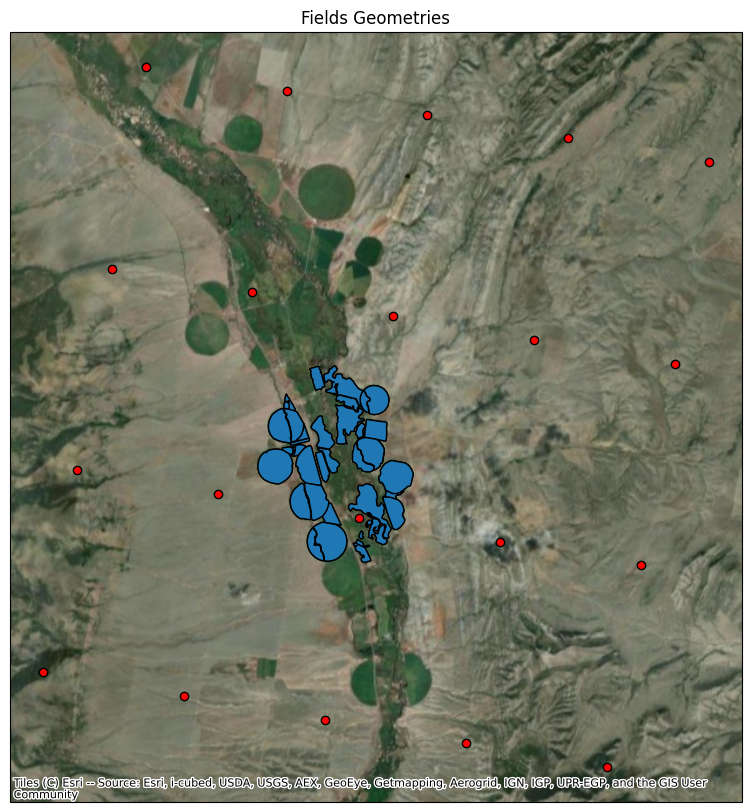

In [4]:
import matplotlib.pyplot as plt
import contextily as ctx
import cartopy.crs as ccrs  # Import cartopy

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})  # Create GeoAxes

# Plot your shapefiles, specifying the CRS
cdf.plot(ax=ax, edgecolor='black', transform=ccrs.epsg(5071), color='red')  
gdf.plot(ax=ax, edgecolor='black', transform=ccrs.epsg(5071))

# Add basemap, reprojecting it to match your shapefiles' CRS
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('Fields Geometries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The code in `find_gridmet_points` associates each field with GridMET cell and pulls the bias-correction factor from the .tif raster bias correction surfaces. 

Note: the included bias-correction GeoTIFFs are projected in an equal area projection, EPSG 5071, as are the shapefiles we've been using. If the raster and shapefiles are not both in the same projection, the data extracted for the bias correction will be incorrect.

The code writes a new shapefile with the attribute 'GFID' which is the unique ID for each GridMET cell. It also writes a .json file with a dict that contains each month's bias correction factor for each field.

In [5]:
# append the project path to the environment (mine is in /home/dgketchum/PycharmProjects')
sys.path.append('/home/dgketchum/PycharmProjects/swim-rs')

# import the function from the module
from data_extraction.gridmet.gridmet import find_gridmet_points

# We must specify which column in the shapefile represents the field's unique ID, in this case it is 'FID_1'
FEATURE_ID = 'FID_1'

# run the GridMET-Field matching analysis, and pull the bias correction factors:
correction_tifs = 'bias_correction_tif'

# same fields shapefile, but with the 'GFID' attribute added
fields_gridmet = 'mt_sid_boulder_gfid.shp'

# .json file with a dict of fieds and 12 bias correction factors each, one for each month
gridmet_factors = 'mt_sid_boulder_gfid.json'

find_gridmet_points(fields=shapefile_path, 
                    gridmet_points=cetnroids_path, 
                    gridmet_ras=correction_tifs, 
                    fields_join=fields_gridmet, 
                    factors_js=gridmet_factors, 
                    feature_id=FEATURE_ID)


Find field-gridmet joins


  0%|                                                                                                          | 0/78 [00:00<?, ?it/s]

Matched 043_000153 to 111190


/home/dgketchum/miniconda3/envs/swim/lib/python3.9/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:29<00:00,  2.61it/s]

Get gridmet for 4 target points


Note: This should print 'Get gridmet for 4 target points', as there should be only four unique GridMET cells that are closest each of the fields. 

Let's plot the fields colored according to the GFID, so we can assure ourselves this worked correctly:

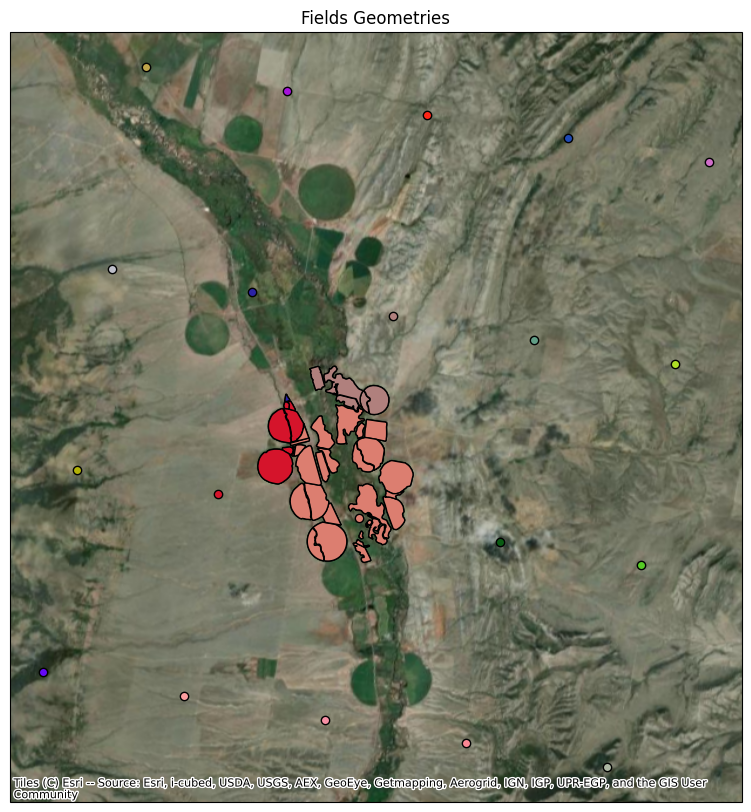

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx
import cartopy.crs as ccrs
import random

# The following code raises a UserWarning that doesn't affect us, so we suppress it
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.") 

gdf_gfid = gpd.read_file(fields_gridmet)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})

# Get a list of unique GFID values
unique_gfids = set(cdf['GFID'].unique()).union(gdf_gfid['GFID'].unique())

# Generate a random color palette with enough colors for all unique GFIDs
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(unique_gfids))]

# Create a dictionary mapping GFID values to colors
color_map = dict(zip(unique_gfids, colors))

# Plot the shapefiles, using the color map to assign colors based on GFID
for gfid, color in color_map.items():
    cdf[cdf['GFID'] == gfid].plot(ax=ax, edgecolor='black', color=color, transform=ccrs.epsg(5071))
    gdf_gfid[gdf_gfid['GFID'] == gfid].plot(ax=ax, edgecolor='black', color=color, transform=ccrs.epsg(5071))

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title('Fields Geometries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We can see that (hopefully) each field's color matches that of the nearest GridMET centroid. The 'GFID' for each field has been saved in the `'mt_sid_boulder_gfid.shp'`This reduces the data we must download by a large factor, and is especially important when we run this workflow on a sample with thousands of clustered fields. 

In [7]:
## TODO: add functionality and tutorial on using the GridMET .nc stack for extractions